In [151]:
# 1) Load datasets from the Hadoop file system into Spark DataFrames

# import libraries
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import matplotlib.pyplot as plt

# initialise spark session
spark = SparkSession.builder.appName("INFS3208 Individual Project").getOrCreate()
# create a SparkContext object to communicate with the spark spark cluster
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# create schemas for each csv file in Hadoop file system
# adapted code from https://mungingdata.com/pyspark/schema-structtype-structfield/
egm_schema = StructType([StructField("Date", StringType(), True),\
                         StructField("LGA", StringType(), True),\
                         StructField("Approved_Sites", IntegerType(), True),\
                         StructField("Operational_Sites", IntegerType(), True),\
                         StructField("Approved_EGM", IntegerType(), True),\
                         StructField("Operational_EGM", IntegerType(), True),\
                         StructField("Metered_Win", DoubleType(), True)])

erp_schema = StructType([StructField("Dataflow", StringType(), True),\
                         StructField("Sex", StringType(), True),\
                         StructField("Person_Characteristics", StringType(), True),\
                         StructField("LGA", StringType(), True),\
                         StructField("Region_Type", StringType(), True),\
                         StructField("State", StringType(), True),\
                         StructField("Year", IntegerType(), True),\
                         StructField("ERP", IntegerType(), True)])

# load the datasets from HDFS file system into Spark DataFrames
# adapted code from https://sparkbyexamples.com/spark/spark-read-csv-file-into-dataframe/#inferschema
egm_data = spark.read.format("csv").option("header","true").schema(egm_schema).load("hdfs://namenode:9000/datasets/monthly-EGM-data.csv")
erp_data = spark.read.format("csv").option("header","true").schema(erp_schema).load("hdfs://namenode:9000/datasets/ERPs-2021.csv")

# show the top 20 rows of each DataFrame
egm_data.show()
erp_data.show()


+------+-----------------+--------------+-----------------+------------+---------------+-------------+
|  Date|              LGA|Approved_Sites|Operational_Sites|Approved_EGM|Operational_EGM|  Metered_Win|
+------+-----------------+--------------+-----------------+------------+---------------+-------------+
|Jul-04|          BALONNE|             7|                6|          74|             74|    139309.64|
|Jul-04|           BANANA|            11|               11|         183|            183|    296541.83|
|Jul-04|       BARCALDINE|             3|                3|          28|             28|         null|
|Jul-04|   BLACKALL TAMBO|             3|                3|          26|             26|         null|
|Jul-04|         BRISBANE|           242|              230|        8801|           8370|3.259112298E7|
|Jul-04|        BUNDABERG|            43|               42|        1014|            968|   3468944.68|
|Jul-04|         BURDEKIN|             8|                8|         185| 

In [152]:
# 2a) Data Preprocessing

# find number of records in each DataFrame before preprocessing
original_egm_data_records = egm_data.count()
original_erp_data_records = erp_data.count()

# egm_data preprocessing:
# Metered wins are purposefully not released for LGAs with < 5 operating sites for privacy reasons so all these values
# are NULL. Furthermore, NULL values can appear in the Operational_Sites, Operational_EGM and Metered_Win columns in cases 
# where there have been no operational sites or no operational EGMs.
# Change the above listed NULL cases to 0 (as these are not errors in the data).
print("Null, None, NaN values in each egm_data column before accounting for previously mentioned purposeful NULLs.")
# below code adapted from https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/#:~:text=In%20PySpark%20DataFrame%20you%20can,count()%20and%20when().
original_null_values = egm_data.select([count(when(isnan(c) | col(c).isNull(), c))\
                                        .alias(c) for c in egm_data.columns]).show()

egm_data = egm_data.withColumn("Metered_Win", when(((egm_data.Operational_Sites <= 5)\
                                                    | (egm_data.Operational_Sites.isNull())\
                                                    | (egm_data.Operational_EGM.isNull()))\
                                                   & (egm_data.Metered_Win.isNull()), 0)\
                               .otherwise(egm_data.Metered_Win))\
                    .withColumn("Operational_Sites", when(egm_data.Operational_Sites.isNull(), 0)\
                                .otherwise(egm_data.Operational_Sites))\
                    .withColumn("Operational_EGM", when(egm_data.Operational_EGM.isNull(), 0)\
                                .otherwise(egm_data.Operational_EGM))

print("Null, None, NaN values in each egm_data column after accounting for previously mentioned purposeful NULLs.")
new_null_values = egm_data.select([count(when(isnan(c) | col(c).isNull(), c))\
                                   .alias(c) for c in egm_data.columns]).show()

# remove records with any leftover null values and duplicates (as these would be errors in the data)
egm_data = egm_data.dropDuplicates().dropna(how="any")
print("Leftover null values and duplicates removed " + str(original_egm_data_records - egm_data.count())\
      + " records from egm_data.")

# turn Date column from type String to Date object (this format has more query writing benefits)
# only capitalise the first letter of LGAs to be consistent with the erp_data DataFrame
egm_data = egm_data.withColumn("Date", to_date(col("Date"),"LLL-yy"))\
                    .withColumn("LGA", initcap(lower(col("LGA"))))

Null, None, NaN values in each egm_data column before accounting for previously mentioned purposeful NULLs.
+----+---+--------------+-----------------+------------+---------------+-----------+
|Date|LGA|Approved_Sites|Operational_Sites|Approved_EGM|Operational_EGM|Metered_Win|
+----+---+--------------+-----------------+------------+---------------+-----------+
|   0|  0|             0|              239|           0|            239|       3607|
+----+---+--------------+-----------------+------------+---------------+-----------+

Null, None, NaN values in each egm_data column after accounting for previously mentioned purposeful NULLs.
+----+---+--------------+-----------------+------------+---------------+-----------+
|Date|LGA|Approved_Sites|Operational_Sites|Approved_EGM|Operational_EGM|Metered_Win|
+----+---+--------------+-----------------+------------+---------------+-----------+
|   0|  0|             0|                0|           0|              0|          0|
+----+---+---------

In [153]:
# erp_data preprocessing:
# filter data to remove all data points outside the project's scope and outliers 
# (e.g. filter out all states' LGA populations except Qld)
erp_data = erp_data.filter(erp_data.State.contains("Queensland"))\
                    .filter(erp_data.Person_Characteristics.contains("Age groups:"))\
                    .withColumnRenamed("Person_Characteristics", "Age_Group")\
                    .filter(erp_data.Sex.contains("Persons"))\
                    .drop("Dataflow")\
                    .drop("Region_Type")\
                    .drop("Year")\
                    .drop("State")\
                    .drop("Sex")

# preprocess LGA column:
# remove LGA ID and colon from String name and only capitalise first letter of each word 
# to match egm_data (e.g. McKinlay -> Mckinlay)
# remove 2 outlier values in LGA i.e. those will no usual address and those who are migratory
erp_data = erp_data.withColumn("LGA", when(erp_data.LGA.contains(":"), element_at(split(col("LGA"),": "),2))\
                               .otherwise(erp_data.LGA))\
                    .withColumn("LGA", initcap(lower(col("LGA"))))\
                    .filter(~erp_data.LGA.contains("No usual address")\
                            & ~erp_data.LGA.contains("Migratory"))

# remove substring "(qld)" for those LGA names that include it
erp_data = erp_data.withColumn("LGA", regexp_replace("LGA"," \(qld\)",""))

# check number of distinct LGA values - 78 is correct
distinct_erp_LGAs = erp_data.select("LGA").distinct().count()
print("QLD has 78 LGAs. The number of distinct LGAs used in the erp_data DataFrame are: "\
      + str(distinct_erp_LGAs) + ".")

# check that egm_data.LGA names is a subset of erp_data.LGA and hence uses the exact same LGA names
egm_LGA = set(egm_data.select(egm_data.LGA).rdd.flatMap(lambda x: x).collect())
erp_LGA = set(erp_data.select(erp_data.LGA).rdd.flatMap(lambda x: x).collect())
check_subset = egm_LGA.issubset(erp_LGA)
print("Are the LGA names used in egm_data now a subset of those used in the erp_data? " + str(check_subset))

# preprocess Person_Characteristics column:
# remove unnecessary text from Age_Group column values
# remove 0-4 and 4-14 age groups (as children cannot use EGMs)
erp_data = erp_data.withColumn("Age_Group",\
                               when(erp_data.Age_Group.contains(":"), element_at(split(col("Age_Group"),": "),3))\
                               .otherwise(erp_data.Age_Group))\
                    .filter(~erp_data.Age_Group.contains("0-4")\
                            & ~erp_data.Age_Group.contains("5-14"))

# remove records with any leftover null values and duplicates (as these would be errors in the data)
null_values_before = erp_data.count()
erp_data = erp_data.dropDuplicates().dropna(how="any")
print("Null values and duplicates removed " + str(null_values_before - erp_data.count())\
      + " records from erp_data.")

print("\n-------------------------------------------------------------------------------------------------------------------")

print("\nThe DataFrame egm_data began with " + str(original_egm_data_records) + " records. It now has "\
      + str(egm_data.count()) + " records.")
egm_data.show()

print("\nThe DataFrame erp_data began with " + str(original_erp_data_records) + " records. It now has "\
      + str(erp_data.count()) + " records.")
erp_data.show()


QLD has 78 LGAs. The number of distinct LGAs used in the erp_data DataFrame are: 78.
Are the LGA names used in egm_data now a subset of those used in the erp_data? True
Null values and duplicates removed 0 records from erp_data.

-------------------------------------------------------------------------------------------------------------------

The DataFrame egm_data began with 12045 records. It now has 12045 records.
+----------+-----------------+--------------+-----------------+------------+---------------+-------------+
|      Date|              LGA|Approved_Sites|Operational_Sites|Approved_EGM|Operational_EGM|  Metered_Win|
+----------+-----------------+--------------+-----------------+------------+---------------+-------------+
|2004-07-01|         Mckinlay|             2|                2|          21|             21|          0.0|
|2004-12-01|           Winton|             4|                4|          39|             39|          0.0|
|2005-03-01|       Scenic Rim|            2

In [154]:
# 2b) Data Exploration of egm_data

egm_data.registerTempTable("Egm")

# number of LGAs with approved EGM sites
print("Number of LGAs with approved EGM sites:")
spark.sql("SELECT COUNT(DISTINCT LGA) as Distinct_LGA_Count FROM Egm").show()
print("There are " + str(distinct_erp_LGAs - egm_data.select("LGA").distinct().count())\
      + " LGAs that do not have any approved sites nor EGMs.\n")

# earliest and most recent months with EGM data and the total number of months with data
print("Months included in DataFrame:")
spark.sql("""SELECT MIN(Date) as Earliest_Month, MAX(Date) as Latest_Month, 
COUNT(DISTINCT Date) as Distinct_Month_Count FROM Egm""").show()

# total metered wins (i.e. players' losses) from 07/04 - 09/22
# (does not include player losses from LGAs with <= 5 operational sites and may not account for the time value of money)
print("Total player losses from 07/04 - 09/22:")
spark.sql("""SELECT ROUND(SUM(Metered_Win)/1000000000,3) as Total_Player_Losses_Billions FROM Egm""").show()


Number of LGAs with approved EGM sites:
+------------------+
|Distinct_LGA_Count|
+------------------+
|                55|
+------------------+

There are 23 LGAs that do not have any approved sites nor EGMs.

Months included in DataFrame:
+--------------+------------+--------------------+
|Earliest_Month|Latest_Month|Distinct_Month_Count|
+--------------+------------+--------------------+
|    2004-07-01|  2022-09-01|                 219|
+--------------+------------+--------------------+

Total player losses from 07/04 - 09/22:
+----------------------------+
|Total_Player_Losses_Billions|
+----------------------------+
|                      37.732|
+----------------------------+



In [155]:
# Monthly player losses from EGMs in specific LGAs:

# smallest monthly losses in a specific LGA with more than 5 operational sites
# (LGAs with less than 5 operational sites all have a 0 dollar value for privacy reasons)
print("Smallest monthly player losses in a specific LGA:")
spark.sql("""SELECT Date, LGA, ROUND(Metered_Win,2) as Player_Losses FROM Egm
WHERE Metered_Win = (SELECT MIN(Metered_Win) FROM Egm WHERE Operational_Sites > 5)""").show()

# greatest monthly losses in a specific LGA
print("Largest monthly player losses in a specific LGA:")
spark.sql("""SELECT Date, LGA, ROUND(Metered_Win/1000000,2) as Player_Losses_Millions FROM Egm
WHERE Metered_Win = (SELECT MAX(Metered_Win) FROM Egm)""").show()

# average monthly losses per LGA (exclude LGAs with <= 5 operational sites)
print("Average monthly player losses per LGA:")
spark.sql("""SELECT ROUND(AVG(Metered_Win)/1000000,2) as Average_Monthly_Player_Losses_Millions FROM Egm
WHERE Operational_Sites > 5""").show()


Smallest monthly player losses in a specific LGA:
+----------+---------+-------------+
|      Date|      LGA|Player_Losses|
+----------+---------+-------------+
|2006-01-01|Longreach|     63339.97|
+----------+---------+-------------+

Largest monthly player losses in a specific LGA:
+----------+--------+----------------------+
|      Date|     LGA|Player_Losses_Millions|
+----------+--------+----------------------+
|2022-07-01|Brisbane|                 63.73|
+----------+--------+----------------------+

Average monthly player losses per LGA:
+--------------------------------------+
|Average_Monthly_Player_Losses_Millions|
+--------------------------------------+
|                                  4.47|
+--------------------------------------+



In [156]:
# Number of operational EGM sites in LGAs in a given month:

# find occurances when LGAs had no operational sites - despite having approved EGM sites
print("Months where LGAs - despite having approved sites - had no operational sites:")
spark.sql("""SELECT Date, Count(*) as Number_LGAs_with_no_Operational_Sites
FROM(SELECT Date, LGA, Operational_Sites FROM Egm 
WHERE Operational_Sites = (SELECT MIN(Operational_Sites) FROM Egm))
GROUP BY Date
ORDER BY Date""").show(30)

# find LGAs that had no operational sites outside of covid lockdowns (03/2020 - 06/2020)
print("LGAs with no operational sites in months excluding those affecting by covid lockdowns:")
spark.sql("""SELECT LGA, COUNT(*) as Number_Months_with_No_Operational_Sites
FROM(SELECT Date, LGA, Operational_Sites FROM Egm 
WHERE (Operational_Sites = (SELECT MIN(Operational_Sites) FROM Egm)) AND (Date < '2020-03-01'))
GROUP BY LGA""").show()

# largest number of operational sites in an LGA in a given month
print("Largest number of operational sites in an LGA in a given month:")
spark.sql("""SELECT Date, LGA, Operational_Sites FROM Egm
WHERE Operational_Sites = (SELECT MAX(Operational_Sites) FROM Egm)""").show()

# average number of operational sites in an LGA in a given month, excluding outlier data (i.e. covid-19 lockdown months)
print("Average number of operational sites in an LGA in a given month:")
spark.sql("""SELECT ROUND(AVG(Operational_Sites), 0) as Average_Number_Operational_Sites FROM Egm
WHERE Date < '2020-03-01'""").show()

Months where LGAs - despite having approved sites - had no operational sites:
+----------+-------------------------------------+
|      Date|Number_LGAs_with_no_Operational_Sites|
+----------+-------------------------------------+
|2015-03-01|                                    1|
|2015-04-01|                                    1|
|2015-05-01|                                    1|
|2015-06-01|                                    1|
|2015-07-01|                                    1|
|2015-08-01|                                    1|
|2015-09-01|                                    1|
|2015-10-01|                                    1|
|2015-11-01|                                    1|
|2015-12-01|                                    1|
|2016-01-01|                                    1|
|2016-02-01|                                    1|
|2016-03-01|                                    1|
|2016-04-01|                                    1|
|2016-05-01|                                    1|
|201

In [157]:
# Number of operational EGMs in LGAs in a given month:

# find occurances when LGAs had no operational EGMs - despite having approved EGMs
print("Months where LGAs - despite having approved EGMs - had no operational EGMs:")
spark.sql("""SELECT Date, Count(*) as Number_LGAs_with_no_Operational_EGMs
FROM(SELECT Date, LGA, Operational_EGM FROM Egm 
WHERE Operational_EGM = (SELECT MIN(Operational_EGM) FROM Egm))
GROUP BY Date
ORDER BY Date""").show(30)

# find LGAs that had no operational EGMs outside of covid lockdowns (03/2020 - 06/2020)
print("LGAs with no operational EGMs in months excluding those affecting by covid lockdowns:")
spark.sql("""SELECT LGA, COUNT(*) as Number_Months_with_No_Operational_EGMs
FROM(SELECT Date, LGA, Operational_EGM FROM Egm 
WHERE (Operational_EGM = (SELECT MIN(Operational_EGM) FROM Egm)) AND (Date < '2020-03-01'))
GROUP BY LGA""").show()

# largest number of operational EGMs in an LGA in a given month
print("Largest number of operational EGMs in an LGA in a given month:")
spark.sql("""SELECT Date, LGA, Operational_EGM FROM Egm
WHERE Operational_EGM = (SELECT MAX(Operational_EGM) FROM Egm)""").show()

# average number of operational EGMs in an LGA in a given month, excluding outlier data (i.e. covid-19 lockdown months)
print("Average number of operational EGMs in an LGA in a given month:")
spark.sql("""SELECT ROUND(AVG(Operational_EGM), 0) as Average_Number_Operational_EGMs FROM Egm
WHERE Date < '2020-03-01'""").show()

Months where LGAs - despite having approved EGMs - had no operational EGMs:
+----------+------------------------------------+
|      Date|Number_LGAs_with_no_Operational_EGMs|
+----------+------------------------------------+
|2015-03-01|                                   1|
|2015-04-01|                                   1|
|2015-05-01|                                   1|
|2015-06-01|                                   1|
|2015-07-01|                                   1|
|2015-08-01|                                   1|
|2015-09-01|                                   1|
|2015-10-01|                                   1|
|2015-11-01|                                   1|
|2015-12-01|                                   1|
|2016-01-01|                                   1|
|2016-02-01|                                   1|
|2016-03-01|                                   1|
|2016-04-01|                                   1|
|2016-05-01|                                   1|
|2016-06-01|            

In [158]:
# 2b) Data Exploration of erp_data

erp_data.registerTempTable("Erp_2021")

# (The ABS categorises the LGA population data by age group ranges, including 15-19 and 20-24. Hence, it's not possible
# to get the estimated adult (18+) population by LGAs. The population of 15+ year olds is instead used to roughly 
# represent the population who has access to EGMs. This slightly younger lower bound of 15 also accounts for the 
# fact some underage teenagers - whilst it's illegal for them to enter gaming venues - have still gambled using 
# EGMs and hence have partly contributed to the metered wins.)

# total 15+ year old QLD population
print("Total 15+ year old population in QLD, 2021:")
spark.sql("""SELECT SUM(ERP) as Total_15Over_Population
FROM Erp_2021""").show()

# 15+ y/o population by LGAs
print("LGAs with the largest 15+ year old population, 2021:")
Adult_Population = spark.sql("""SELECT LGA, SUM(ERP) as Total_15Over_ERP
FROM Erp_2021
GROUP BY LGA
ORDER BY Total_15Over_ERP DESC""")
Adult_Population.show(3)

print("LGAs with the smallest 15+ year old population, 2021:")
spark.sql("""SELECT LGA, SUM(ERP) as Total_15Over_ERP
FROM Erp_2021
GROUP BY LGA
ORDER BY Total_15Over_ERP""").show(3)

# Average 15+ y/o population per LGA:
Adult_Population.registerTempTable("Adult_Population")
print("Average 15+ year old population per LGA, 2021:")
spark.sql("""SELECT ROUND(AVG(Total_15Over_ERP),0) as Average_15Over_ERP
FROM Adult_Population""").show()


Total 15+ year old population in QLD, 2021:
+-----------------------+
|Total_15Over_Population|
+-----------------------+
|                4178389|
+-----------------------+

LGAs with the largest 15+ year old population, 2021:
+-----------+----------------+
|        LGA|Total_15Over_ERP|
+-----------+----------------+
|   Brisbane|         1026215|
| Gold Coast|          515151|
|Moreton Bay|          381891|
+-----------+----------------+
only showing top 3 rows

LGAs with the smallest 15+ year old population, 2021:
+-----------+----------------+
|        LGA|Total_15Over_ERP|
+-----------+----------------+
|Wujal Wujal|             198|
|    Croydon|             208|
| Diamantina|             233|
+-----------+----------------+
only showing top 3 rows

Average 15+ year old population per LGA, 2021:
+------------------+
|Average_15Over_ERP|
+------------------+
|           53569.0|
+------------------+



<AxesSubplot:title={'center':'Yearly player losses in QLD'}, xlabel='Year'>

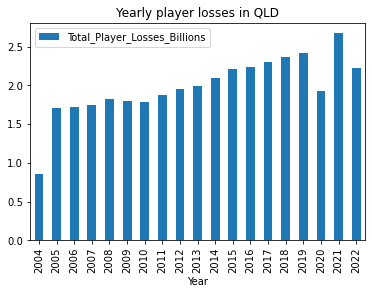

In [159]:
# 2b) Big Data Querying and Visualisation
# The use of pandas to visualise data was learned and some code was adapted from the following sources:
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/#dataframeplotbar
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html
# Blackboard assignment example: Data Analytics for 2021 Olympics in Tokyo by Edward Li
    
# Query 1 - Total yearly player losses in QLD
yearly_player_losses = spark.sql("""SELECT EXTRACT(YEAR FROM Date) as Year,
ROUND(SUM(Metered_Win)/1000000000,3) as Total_Player_Losses_Billions 
FROM Egm
GROUP BY EXTRACT(YEAR FROM Date)
ORDER BY Year""")
yearly_player_losses_graph = yearly_player_losses.toPandas()
yearly_player_losses_graph.plot(kind = 'bar', x = 'Year',\
                                    y ='Total_Player_Losses_Billions', title = 'Yearly player losses in QLD')


<AxesSubplot:title={'center':'LGAs with the largest total player losses for 2005'}, xlabel='LGA'>

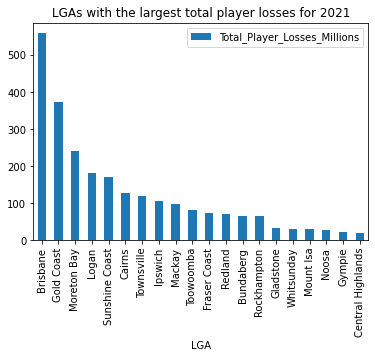

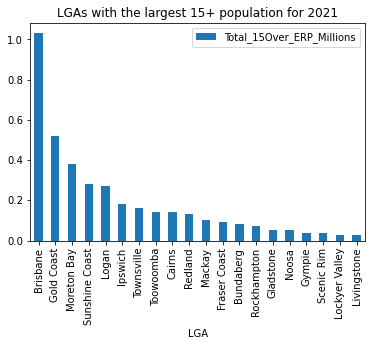

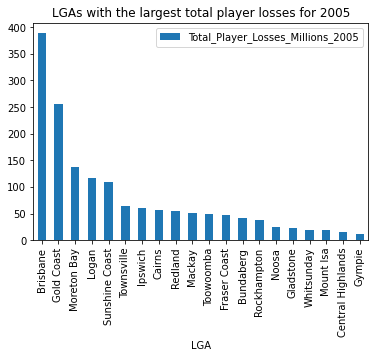

In [165]:
# Query 2 - LGAs with the largest total player losses for 2021
yearly_player_losses_2021 = spark.sql("""SELECT LGA,
ROUND(SUM(Metered_Win)/1000000,2) as Total_Player_Losses_Millions 
FROM Egm
WHERE EXTRACT(YEAR FROM Date) = 2021
GROUP BY LGA
ORDER BY Total_Player_Losses_Millions DESC""")
yearly_player_losses_2021_graph = yearly_player_losses_2021.toPandas()
yearly_player_losses_2021_graph.iloc[0:20].plot(kind = 'bar', x = 'LGA',\
                                    y ='Total_Player_Losses_Millions',\
                                           title = 'LGAs with the largest total player losses for 2021')

# Query 3 - LGAs with the largest 15+ year old total population for 2021
yearly_15Over_ERP = spark.sql("""SELECT LGA, 
ROUND(Total_15Over_ERP/1000000,2) as Total_15Over_ERP_Millions
FROM Adult_Population
ORDER BY Total_15Over_ERP DESC""")
yearly_15Over_ERP_graph = yearly_15Over_ERP.toPandas()
yearly_15Over_ERP_graph.iloc[0:20].plot(kind = 'bar', x = 'LGA',\
                                    y ='Total_15Over_ERP_Millions',\
                                           title = 'LGAs with the largest 15+ population for 2021')

# Query 4 - LGAs with the largest population for 2005
yearly_player_losses_2005 = spark.sql("""SELECT LGA,
ROUND(SUM(Metered_Win)/1000000,2) as Total_Player_Losses_Millions_2005 
FROM Egm
WHERE EXTRACT(YEAR FROM Date) = 2005
GROUP BY LGA
ORDER BY Total_Player_Losses_Millions_2005 DESC""")
yearly_player_losses_2005_graph = yearly_player_losses_2005.toPandas()
yearly_player_losses_2005_graph.iloc[0:20].plot(kind = 'bar', x = 'LGA',\
                                    y ='Total_Player_Losses_Millions_2005',\
                                           title = 'LGAs with the largest total player losses for 2005')
